In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
%matplotlib widget

### Constante

In [2]:
ua = 149597870700 # m/ua
d = 86400 # s/d
m_sun = 1.9885e30 # kg/m_Sun
G = 6.67430e-11 # m³/kg/s² 
G = G*(86400**2)*m_sun/(ua**3) # ua³/m_Sun/d²
masses = [1, 1.898e27/1.9885e30] # [Sun, Jupiter] in m_Sun


### Repères
Nomenclature : coord_astre1_astre2 = coordonnées de l'astre 1 par rapport à l'astre 2

Je vais travailler par rapport au Soleil en (0,0,0) et plus le CM


In [3]:
# Changement de repères et d'unités d'angles
hms_to_rad = lambda x: 2*np.pi/24* (x[0]+x[1]/60+x[2]/3600)
dms_to_rad = lambda x: 2*np.pi/360*(x[0]+x[1]/60+x[2]/3600)
coord_2D = lambda r,phi,theta: np.array([r*np.cos(phi),r1*np.sin(phi),0.])
coord_3D = lambda r,phi,theta: np.array([r*np.cos(phi)*np.sin(theta),r*np.sin(phi)*np.sin(theta),r*np.cos(theta)])

# Calcul position 1
RA_hms1 = [3,38,37.78488]
DEC_dms1 = [18,32,57.7628]
RA_rad1 = hms_to_rad(RA_hms1)
DEC_rad1 = np.pi/2-dms_to_rad(DEC_dms1)
r1 = 5.012361271
# Coordinates from the Sun
coord_Sun_Sun1 = np.zeros(3)
coord_Jup_Sun1 = coord_2D(r1,RA_rad1,DEC_rad1)
# Coordinates from the CM
R1 = masses[1]*coord_Jup_Sun1/(masses[0]+masses[1])
coord_Jup_CM1 = coord_Jup_Sun1-R1
coord_Sun_CM1 = coord_Sun_Sun1-R1

# Calcul position 2
RA_hms2 = [3,38,37.78513]
DEC_dms2 = [18,32,57.7637]
RA_rad2 = hms_to_rad(RA_hms2)
DEC_rad2 = np.pi/2-dms_to_rad(DEC_dms2)
r2 = 5.012361274
# Coordinates from the Sun
coord_Sun_Sun2 = coord_Sun_Sun1
coord_Jup_Sun2 = coord_2D(r2,RA_rad2,DEC_rad2)
# Coordinates from the CM
R2 = masses[1]*coord_Jup_Sun2/(masses[0]+masses[1])
coord_Jup_CM2 = coord_Jup_Sun2-R2
coord_Sun_CM2 = coord_Sun_Sun2-R2

# Calcul vitesse (approx linéaire aval)
# Par rapport au Sun
vit_Sun_Sun = np.array([0.,0.,0.]) 
vit_Jup_Sun = (coord_Jup_Sun2-coord_Jup_Sun1)*86400
# Par rapport au CM
vit_Sun_CM = (coord_Sun_CM2-coord_Sun_CM1)*86400
vit_Jup_CM = (coord_Jup_CM2-coord_Jup_CM1)*86400

print(coord_Sun_Sun1)
print(coord_Jup_Sun1)
# print(coord_Sat_Sun1)
print(vit_Sun_CM)
print(vit_Jup_CM)
# print(vit_Sat)

[0. 0. 0.]
[2.89946927 4.08862366 0.        ]
[ 5.98127804e-06 -4.34304836e-06  0.00000000e+00]
[-0.00626648  0.00455013  0.        ]


### Méthode

In [4]:
def Init_Cond(N, masses, pos, vit):
    """
    === Params ===\n
    N :     Number of body
    pos :   2D array of positions
            First index : body (0 -> Sun, 1 -> Jupiter, ...)
            Second index : coordinates [x, y, z]
    vit :   2D array of momentum
            First index : body (0 -> Sun, 1 -> Jupiter, ...)
            Second index : momentum [x, y, z]
    === Return ===\n
    pos_init :  1D array of positions [x_Sun, y_Sun, z_Sun, x_Jup, ...]
    vit_init :  1D array of momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
    """
    pos_init = np.zeros(N*3)
    mom_init = np.zeros(N*3)
    for i in range(N):
        pos_init[i*3] = pos[i][0]
        pos_init[i*3+1] = pos[i][1]
        pos_init[i*3+2] = pos[i][2]

        mom_init[i*3] = vit[i][0]*masses[i]
        mom_init[i*3+1] = vit[i][1]*masses[i]
        mom_init[i*3+2] = vit[i][2]*masses[i]
    return pos_init, mom_init

def distance(x1,x2):
    return (np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2+(x1[2]-x2[2])**2))

def dpos_dt(pos,mom,masses):
    N = len(masses)
    dpos = np.zeros_like(pos)
    for i in range(N):
        j = i*3
        dpos[j:j+3] = mom[j:j+3]/masses[i]
    return dpos

def dmom_dt(pos,mom,masses):
    N = len(masses)
    dmom = np.zeros_like(mom)
    for i in range(N):
        j = i*3
        for k in range(N):
            l = k*3
            if i!=k :
                dmom[j:j+3] += -G*masses[i]*masses[k]/(distance(pos[j:j+3],pos[l:l+3])**3)*(pos[j:j+3]-pos[k:k+3])
    return dmom

def energy(pos,mom,masses):
    N = len(masses)
    kin = 0
    pot = 0
    for i in range(N):
        j = i*3
        kin += 1/2*np.dot(mom[j:j+3],mom[j:j+3])/masses[i]
        for k in range(i+1,N):
            l = k*3
            pot += G*masses[i]*masses[k]/(distance(pos[j:j+3],pos[l:l+3])**2)
    return kin-pot


In [5]:
def Eula(G, masses, pos_init, mom_init, dt, tmax):
    """
    === Params ===\n
    masses :    array of masses [Sun, Jupiter]
    pos_init :  2D array of position
                First axis : coordinates [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep            
    mom_init :    2D array of momentum
                First axis : momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep
    === Return ===\n
    dict :      't' :   1D array of timestep
                'pos' : 2D array of positions
                        First index : coordinates
                        Second index : timestep
                'mom' : 2D array of momentum
                        First index : coordinate
                        Second index : timestep
                'E' :   1D array of energy through time
    """
    t = np.arange(0,tmax+dt,dt)
    pos = np.zeros((len(pos_init),len(t)))
    mom = np.zeros((len(mom_init),len(t)))
    E = np.zeros(len(t))
    pos[:,0] = pos_init
    mom[:,0] = mom_init
    E[0] = energy(pos[:,0], mom[:,0],masses)
    for i in range(len(t)-1):
        mom[:,i+1] = mom[:,i] + dt*dmom_dt(pos[:,i],mom[:,i],masses)
        pos[:,i+1] = pos[:,i] + dt*dpos_dt(pos[:,i],mom[:,i],masses)
        E[i+1] = energy(pos[:,i+1], mom[:,i+1],masses) 
    return {'t':t, 'pos':pos, 'mom': mom, 'E':E}

In [6]:
def Heun(G, masses, pos_init, mom_init, dt, tmax):
    """
    === Params ===\n
    masses :    array of masses [Sun, Jupiter]
    pos_init :  2D array of position
                First axis : coordinates [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep            
    mom_init :    2D array of momentum
                First axis : momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep
    === Return ===\n
    dict :      't' :   1D array of timestep
                'pos' : 2D array of positions
                        First index : coordinates
                        Second index : timestep
                'mom' : 2D array of momentum
                        First index : coordinate
                        Second index : timestep
                'E' :   1D array of energy through time
    """
    t = np.arange(0,tmax+dt,dt)
    pos = np.zeros((len(pos_init),len(t)))
    mom = np.zeros((len(mom_init),len(t)))
    E = np.zeros(len(t))
    pos[:,0] = pos_init
    mom[:,0] = mom_init
    E[0] = energy(pos[:,0], mom[:,0],masses)
    for i in range(len(t)-1):
        mom_tilde = mom[:,i] + dt*dmom_dt(pos[:,i],mom[:,i],masses)
        pos_tilde = pos[:,i] + dt*dpos_dt(pos[:,i],mom[:,i],masses)

        mom[:,i+1] = mom[:,i] + dt/2*(dmom_dt(pos_tilde,mom_tilde,masses)+dmom_dt(pos[:,i],mom[:,i],masses))
        pos[:,i+1] = pos[:,i] + dt/2*(dpos_dt(pos_tilde,mom_tilde,masses)+dpos_dt(pos[:,i],mom[:,i],masses))
        
        E[i+1] = energy(pos[:,i+1], mom[:,i+1], masses)
    return {'t':t,'pos':pos,'mom':mom,'E':E}

In [7]:
def SV(G, masses, pos_init, mom_init, dt, tmax):
    """
    === Params ===\n
    masses :    array of masses [Sun, Jupiter]
    pos_init :  2D array of position
                First axis : coordinates [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep            
    mom_init :    2D array of momentum
                First axis : momentum [x_Sun, y_Sun, z_Sun, x_Jup, ...]
                Second axis : timestep
    === Return ===\n
    dict :      't' :   1D array of timestep
                'pos' : 2D array of positions
                        First index : coordinates
                        Second index : timestep
                'mom' : 2D array of momentum
                        First index : coordinate
                        Second index : timestep
                'E' :   1D array of energy through time
    """
    t = np.arange(0,tmax+dt,dt)
    pos = np.zeros((len(pos_init),len(t)))
    mom = np.zeros((len(mom_init),len(t)))
    E = np.zeros(len(t))
    pos[:,0] = pos_init
    mom[:,0] = mom_init
    E[0] = energy(pos[:,0],mom[:,0],masses)
    for i in range(len(t)-1):
        mmom = mom[:,i] + dt/2*dmom_dt(pos[:,i],mom[:,i],masses)
        pos[:,i+1] = pos[:,i] + dt*dpos_dt(pos[:,i],mmom,masses)
        mom[:,i+1] = mmom + dt/2*dmom_dt(pos[:,i+1],mmom,masses)

        E[i+1] = energy(pos[:,i+1],mom[:,i+1],masses)
    return {'t':t,'pos':pos,'mom':mom,'E':E}

### Calculs

In [8]:
# Conditions initiales
pos_init,mom_init = Init_Cond(2,masses,[coord_Sun_Sun1, coord_Jup_Sun1],[vit_Sun_Sun,vit_Jup_Sun])
# pos_init,mom_init = Init_Cond(2,masses,[coord_Sun_CM1, coord_Jup_CM1],[vit_Sun_CM,vit_Jup_CM])


dt = 30 # nbre de jours par dt
N_tmax = 200 # nbre d'années de la simu
tmax = N_tmax*365 #jours

solEul = Eula(G, masses, pos_init, mom_init,dt, tmax)
solHeun = Heun(G, masses, pos_init, mom_init,dt, tmax)
solSV = SV(G,masses,pos_init,mom_init,dt,tmax)

# np.savetxt(fname="./sun_v.txt", X=solHeun['mom'][0:3,:],delimiter=',')
# np.savetxt(fname="./sun_p.txt", X=solHeun['pos'][0:3,:],delimiter=',')


### Plot Euler

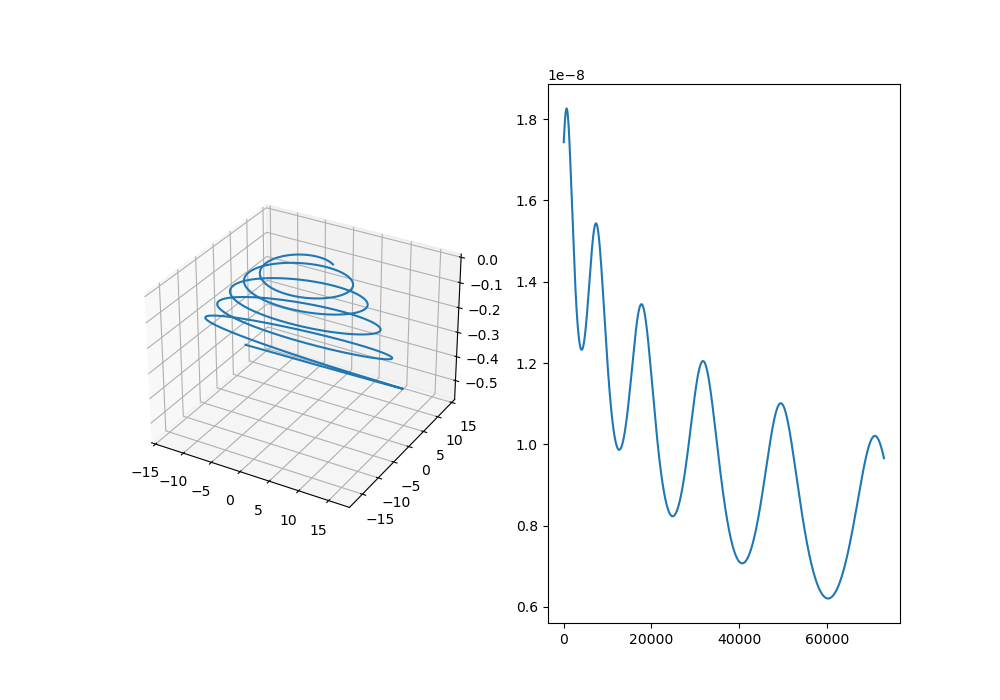

In [9]:
fig= plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.plot(solEul['pos'][3,:],solEul['pos'][4,:],solEul['pos'][5,:])
ax2 = fig.add_subplot(1,2,2)
ax2.plot(solEul['t'],solEul['E'])

plt.show()

### Plot Heun

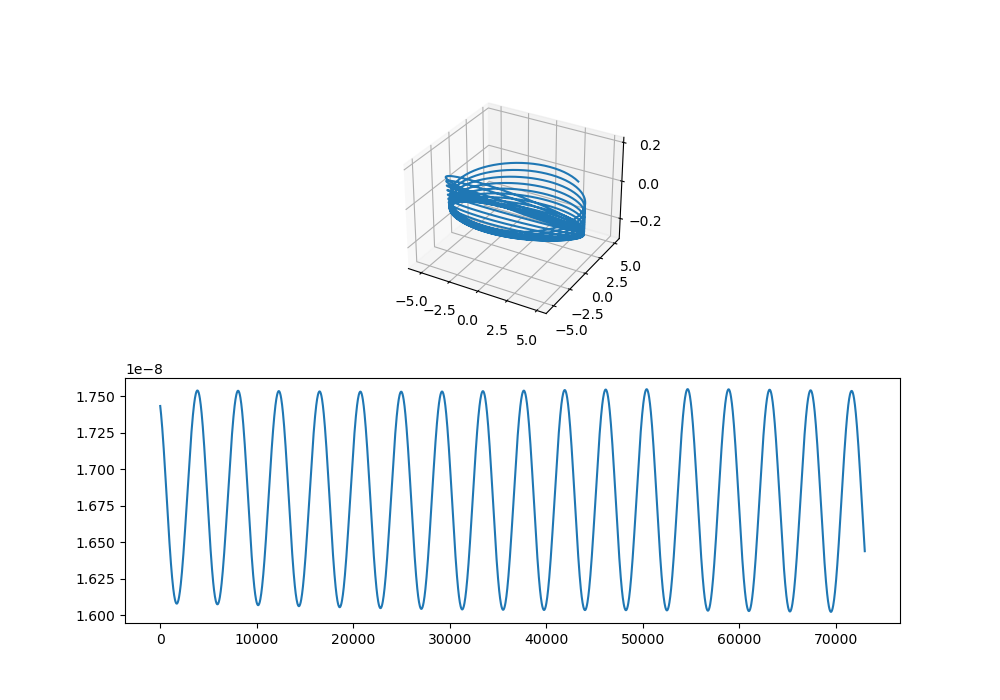

In [10]:
fig= plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(2,1,1,projection='3d')
ax1.plot(solHeun['pos'][3,:],solHeun['pos'][4,:],solHeun['pos'][5,:])
ax2 = fig.add_subplot(2,1,2)
ax2.plot(solHeun['t'],solHeun['E'])

plt.show()

### Plot SV

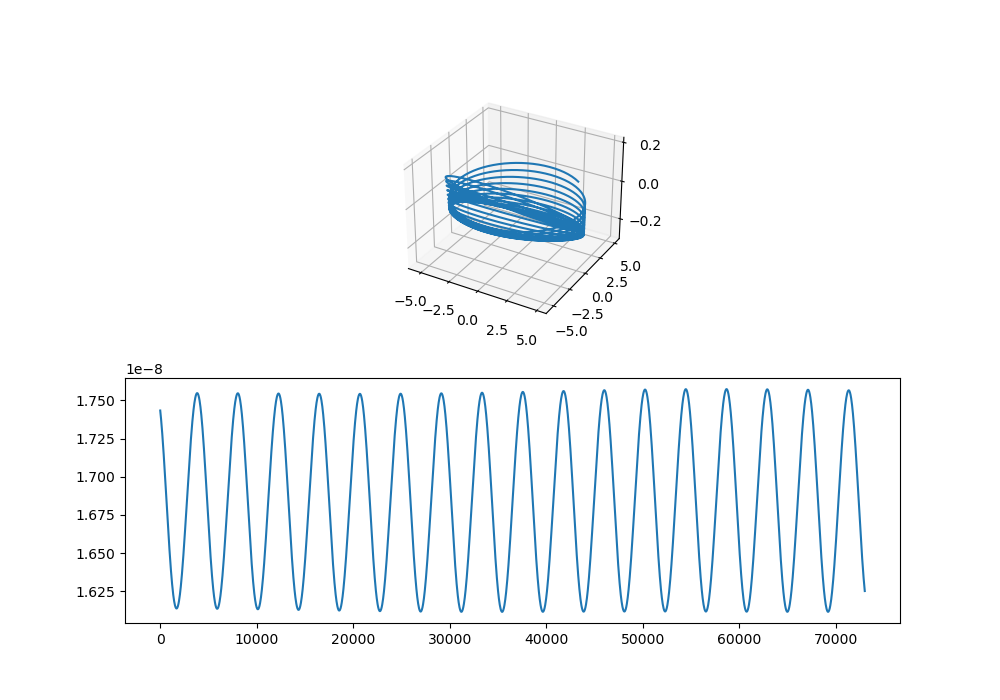

In [11]:
fig= plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(2,1,1,projection='3d')
ax1.plot(solSV['pos'][3,:],solSV['pos'][4,:],solSV['pos'][5,:])
ax2 = fig.add_subplot(2,1,2)
ax2.plot(solSV['t'],solSV['E'])

plt.show()